# Cleanup training data for traffic light detection

Format the data into required input for Keras ImageDataGenerator

In [4]:
import yaml
import decode_traffic as dt
from CameraOperations import load_img, show_grid
import numpy as np
import cv2
from ImageProcessing import weighted_img

def generate_masks(records, rootdir="./data/input", outputdir="./data/output/"):
    '''
    For each record, load the image, clone, generate the mask and save the mask
    '''
    no_records = 0
    for r in records:
        no_records += 1
        filename = r['filename']
        annotation = r['annotations'][0]
        class_name = annotation['class']
        x_width = annotation['x_width']
        xmin = annotation['xmin']
        y_height = annotation['y_height']
        ymin = annotation['ymin']
        mask = np.array([[(xmin, ymin),
                          (xmin+x_width, ymin),
                          (xmin+x_width, ymin+y_height), 
                          (xmin, ymin+y_height), 
                          (xmin,ymin)]], dtype=np.int32)
        image = load_img("{0}/{1}".format(rootdir, filename))
        mask_img = np.zeros_like(image)
        mask_color = dt.TRAFFIC_PALETTE[dt.TRAFFIC_LABELS[class_name]]
        cv2.fillPoly(mask_img, mask, mask_color)
        #merged = weighted_img(image.astype('int16'), mask_img.astype('int16'), α=0.5, β=0.5, λ=0.)
        #show_grid([image.astype("uint8"), mask_img, merged], ["Image", "Mask", "Overlaid"])
        #IMWRITE_JPEG_QUALITY 100
        cv2.imwrite("{0}{1}".format(outputdir, filename), 
                    cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR), 
                    [int(cv2.IMWRITE_PNG_COMPRESSION), 0])


### Processing Real images

In [5]:
stream = open("./real_data_annotations.yaml", "r")
docs = yaml.load_all(stream)

generate_masks(next(docs), rootdir="./data/input/1", outputdir="./data/output/1/")

### Copy simulator files to new names in a new directory

In [ ]:
import shutil
import glob
from os import listdir

src = "./real/sim_training_data/"
images = glob.glob("{0}/sim_data_capture/*.jpg".format(src))
index = "{0}sim_data_annotations.yaml".format(src)
dest = "./data/input/_"
#dest = "./real/test/_"

images = listdir("{0}sim_data_capture/".format(src))

no_files = 0
for img_file in images:
    shutil.copy2("{0}sim_data_capture/{1}".format(src, img_file), "{0}{1}".format(dest, img_file))
    no_files += 1
    
print("Moved {0} files".format(no_files))


### Process Simulator images

In [6]:
def generate_sim_masks(records, rootdir="./data/input", outputdir="./data/output/"):
    '''
    For each record, load the image, clone, generate the mask and save the mask
    '''
    no_records = 0
    for r in records:
        no_records += 1
        filename = r['filename']
        image = load_img("{0}/{1}".format(rootdir, filename))
        mask_img = np.zeros_like(image)
        # Process all annotations
        for annotation in r['annotations']: 
        #annotation = r['annotations'][0]
            class_name = annotation['class']
            x_width = annotation['x_width']
            xmin = annotation['xmin']
            y_height = annotation['y_height']
            ymin = annotation['ymin']
            mask = np.array([[(xmin, ymin),
                              (xmin+x_width, ymin),
                              (xmin+x_width, ymin+y_height), 
                              (xmin, ymin+y_height), 
                              (xmin,ymin)]], dtype=np.int32)
            mask_color = dt.TRAFFIC_PALETTE[dt.TRAFFIC_LABELS[class_name]]
            cv2.fillPoly(mask_img, mask, mask_color)
        #merged = weighted_img(image.astype('int16'), mask_img.astype('int16'), α=0.5, β=0.5, λ=0.)
        #show_grid([image.astype("uint8"), mask_img, merged], ["Image", "Mask", "Overlaid"])
        cv2.imwrite("{0}{1}".format(outputdir, filename), 
                    cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR), 
                    [int(cv2.IMWRITE_PNG_COMPRESSION), 0] )


In [8]:
src = "./real/sim_training_data/"
index = "{0}sim_data_annotations.yaml".format(src)

stream = open(index, "r")
docs = yaml.load_all(stream)

generate_sim_masks(next(docs), rootdir="data/input/1", outputdir="./data/output/1/")

### Test training data


In [ ]:
from pathlib import Path

images = listdir("./data/input/")

skipped = 0

for i in images:
    img = Path("./data/output/{0}".format(i))
    if not img.is_file():
        #print(i)
        shutil.move("./data/input/{0}".format(i), "./data/hold/{0}".format(i))
        skipped += 1

print("Unavailable {}".format(skipped))


# Test Image Generator

In [9]:
from fcnprocessing import ImageDataGenerator

# we create two instances with the same arguments
shift = 0.2
classes = 4
seed = 1
root = "./data/input/"
#root = "./debug_images/"

image_dir = root+"input/"
mask_dir  = root+"output/"
multiplier = 4
batch = 9

def prep(image):
    feature_means = np.array([87.49920968, 93.75553651, 90.62099276])
    return image - feature_means

data_gen_args = dict(rescale=None,
                     fill_mode='constant',
                     cval=0,
                     data_format="channels_last",
                     num_classes=classes)
'''
                     channel_shift_range=128,
                     zoom_range=0.5,
                     featurewise_center=True,
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function=prep,
                     height_shift_range=shift, 
                     width_shift_range=shift,
                     featurewise_std_normalization=True,
                     zca_whitening=True,
                     brightness=5,
                     rotation_range=0)
                     shear_range=0.2,
                     zoom_range=0.2,
'''

image_datagen = ImageDataGenerator(**data_gen_args)

#print("Fitting samples...")
#image_datagen.fit(samples, augment=False, seed=seed)

print("Run Generator...")
image_generator = image_datagen.flow_from_directory(root,
                                                    class_mode='sparse_mask',
                                                    batch_size=batch,
                                                    seed=seed,
                                                    target_size=(608, 800))


Using TensorFlow backend.


Run Generator...
Found 456 images belonging to 1 classes.


Processing 67 : 1/_left0495.png
Processing 146 : 1/left0133.png
Processing 322 : 1/_left0516.png
Processing 250 : 1/_left0610.png
Processing 223 : 1/_left0552.png
Processing 366 : 1/_left0617.png
Processing 380 : 1/_left0017.png
Processing 427 : 1/left0695.png
Processing 436 : 1/_left0460.png



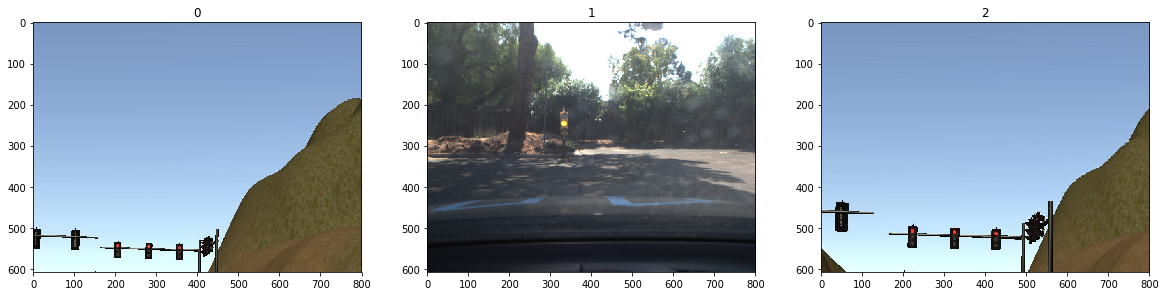

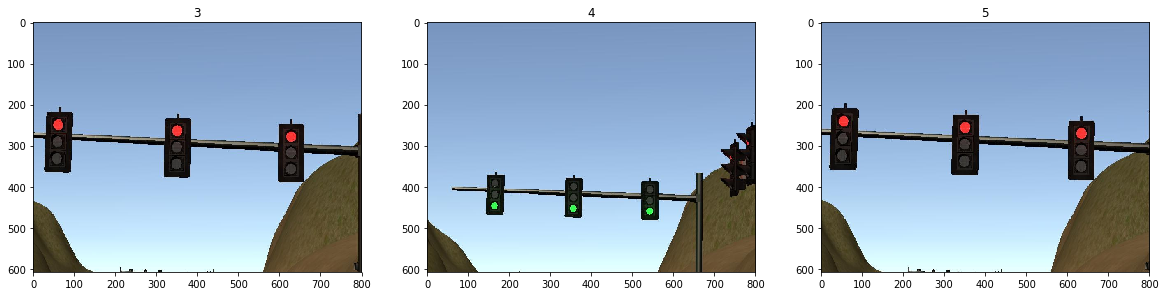

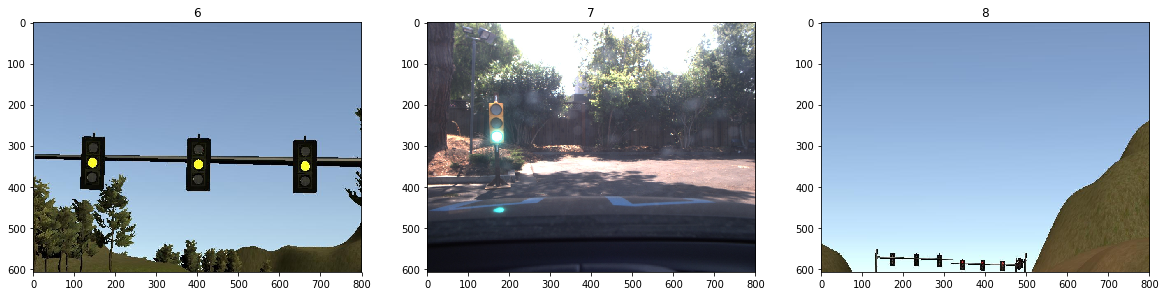

In [10]:
labels = [i for i in range(batch)]
x_batch, y_batch = image_generator.next()

show_grid(x_batch[:3].astype("uint8"), labels[:3])
show_grid(x_batch[3:6].astype("uint8"), labels[3:6])
show_grid(x_batch[6:9].astype("uint8"), labels[6:9])

print()


In [11]:
y_batch.shape

(9, 608, 800, 4)

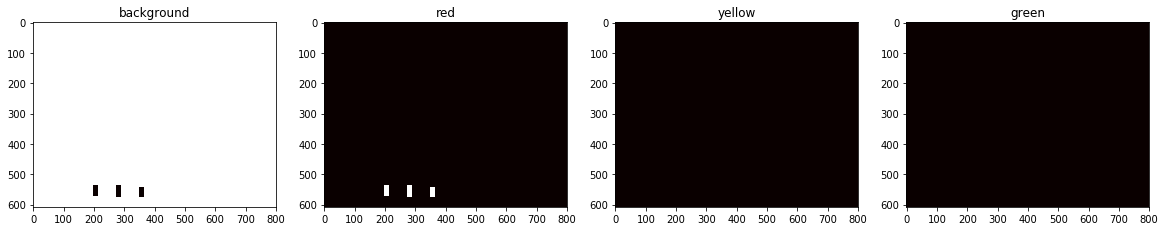

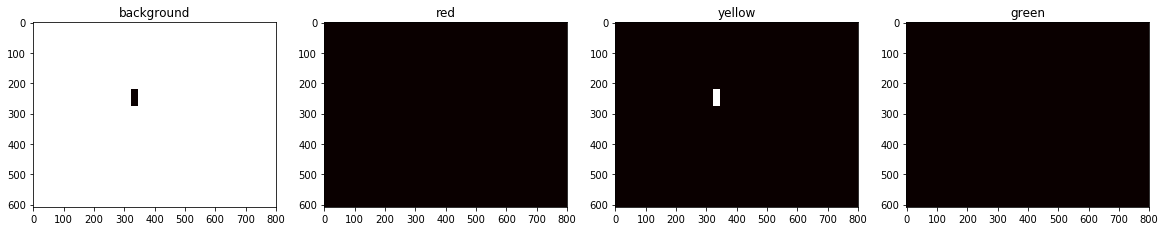

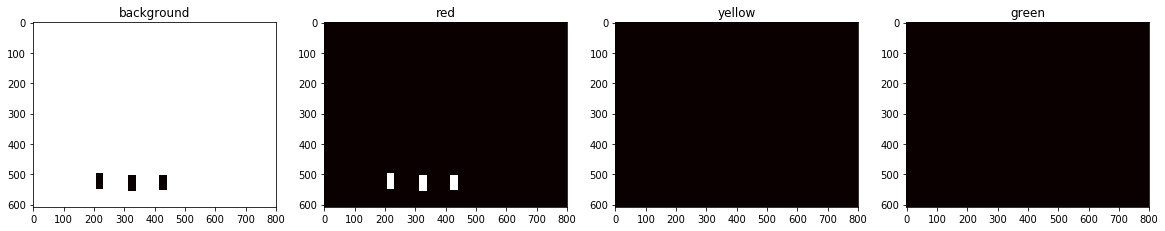

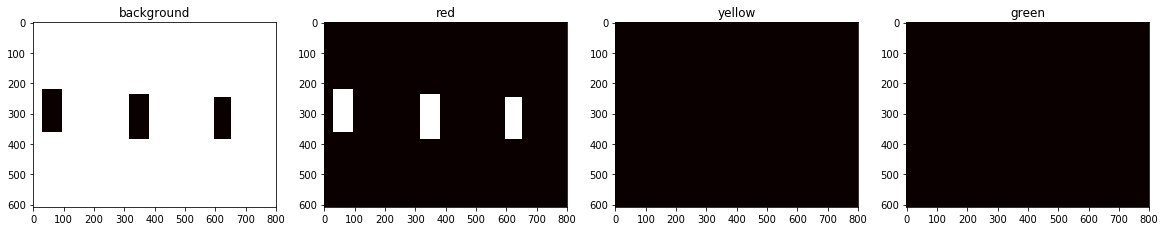

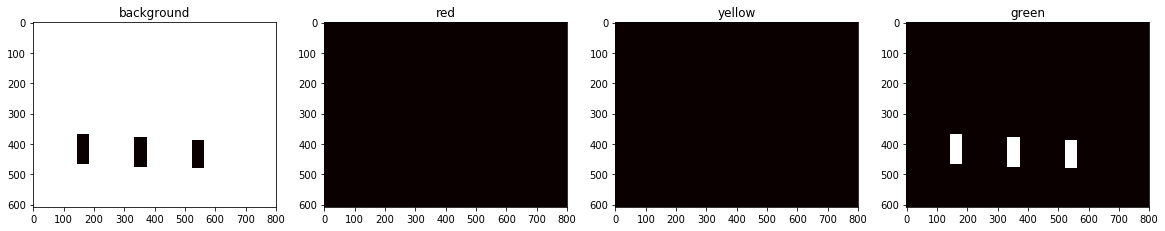

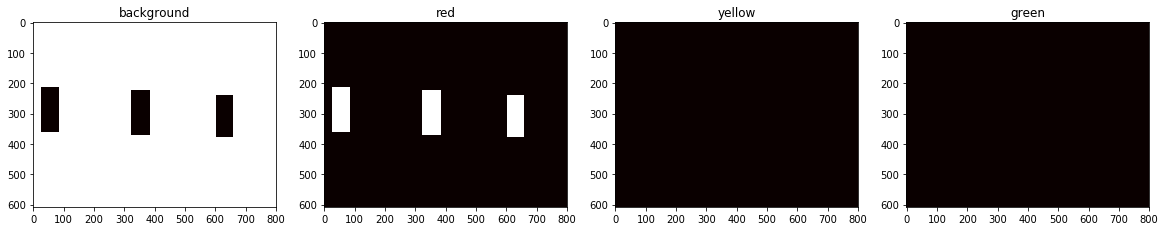

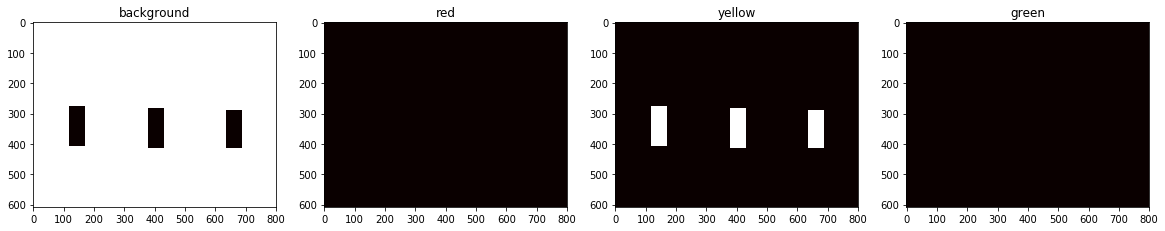

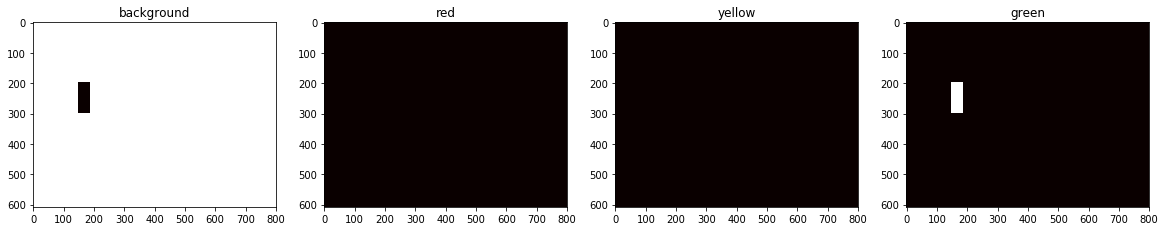

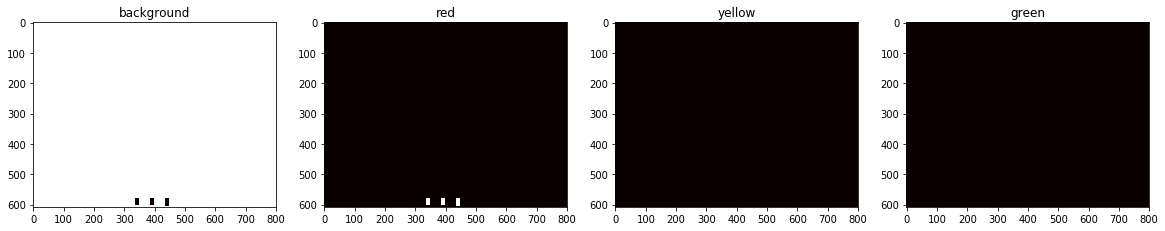

In [12]:

for i in range(len(y_batch)):
    show_grid(y_batch[i].transpose(2, 0, 1), dt.TARGET_CLASS_NAMES, cmap_mono="hot")

'''
masked_imgs = []
tl_masks = y_batch[:,:,:,1]
for i in labels:
    img = apply_mask(x_batch[i], tl_masks[i], color=(255,0,255), threshold=0.05)
    img = weighted_img(image.astype('int16'), mask_img.astype('int16'), α=0.5, β=0.5, λ=0.)
    masked_imgs.append(img)

show_grid(masked_imgs[:4], labels[:4])
show_grid(masked_imgs[4:], labels[4:])
'''
print()


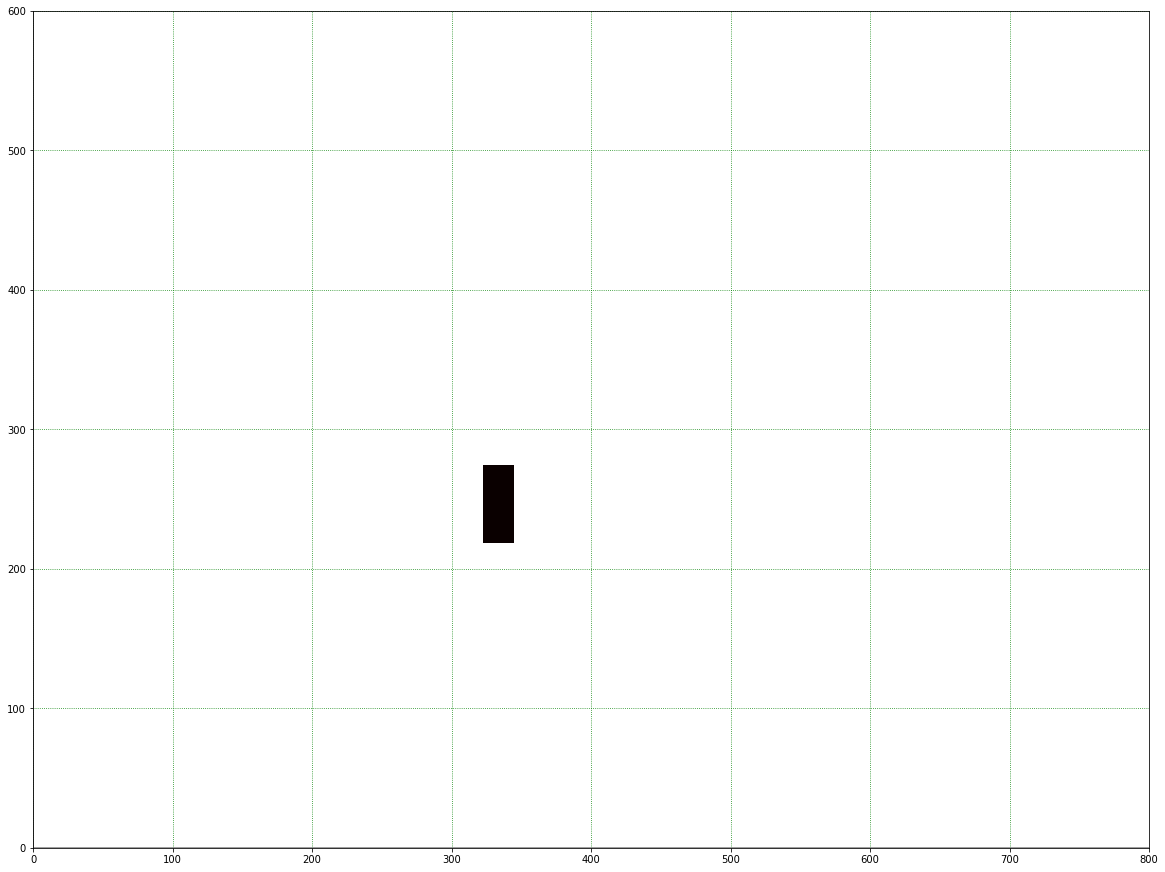

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def setup_plot(xlim=(-50, 50), ylim=(-50, 50), figsize=(20,20)):
    '''
    Grid lines, limits, size and aspect for plot
    '''
    fig, axis = plt.subplots(figsize=figsize)
    axis.grid(b=True, linestyle=':', color='g')
    axis.axhline(y=0, color='gray')
    axis.axvline(x=0, color='gray')
    axis.set_aspect('equal')
    axis.grid(b=True, linestyle=':', color='g')
    axis.set_xlim(xlim[0], xlim[1])
    axis.set_ylim(ylim[0], ylim[1])
    return fig, axis

fig, axis = setup_plot(xlim=(0,800), ylim=(0,600))
plt.imshow(y_batch[1][:,:,0], cmap="hot")

In [14]:
class_mask = y_batch[1][:,:,0]
np.max(class_mask), np.min(class_mask), class_mask.dtype, np.sum(class_mask), np.sum(y_batch[1][:,:,1]), np.sum(y_batch[1][:,:,2]), np.sum(y_batch[1][:,:,3])

(1.0, 0.0, dtype('float32'), 485168.0, 0.0, 1232.0, 0.0)

In [ ]:
class_mask.shape

In [ ]:
from CameraOperations import load_img

img_file = "./data/input/1/_left0022.jpg"
msk_file = "./data/output/1/_left0022.jpg"
'''
img = load_img(img_file)
msk = load_img(msk_file)
show_grid([img.astype("uint8"), msk], ["Image", "Mask"])
'''
img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
msk = cv2.cvtColor(cv2.imread(msk_file), cv2.COLOR_BGR2RGB)
show_grid([img, msk], ["Image", "Mask"])


In [ ]:
from decode_traffic import decode

a = decode(msk)

In [ ]:
a.shape, msk.shape, img.shape

In [ ]:
a_t = a.transpose(2, 0, 1)
a_t.shape

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#show_grid(a_t,  dt.TARGET_CLASS_NAMES)
p = plt.imshow(a_t[2], cmap="hot")

In [ ]:
sign_id, counts = np.unique(msk, return_counts=True)

msk.dtype, sign_id, counts

In [ ]:
from ImageProcessing import get_viewport

snippet = get_viewport(img, x=390,y=390, w=50,h=150, size=None)